##**Overview**

With e-mail becoming one of the most prevalent means of communication, hundreds of billions
of mails are sent every day, making its user experience a top priority to email service providers.
Especially “simplifying the writing process”, which has gained a lot of traction due to the recent,
ever-growing developments and research in the field of language models and Natural Language
processing.

Gmail introduced Smart Reply, a system for automatically generating short replies in response to
incoming e-mail messages. While such a feature significantly reduces user response time, the
suggestions are constrained to short phrases and appear only once in the composition process.
Even with an initial suggestion, drafting longer messages can still be a time-consuming process,
and is arguably one in which the user most needs accurate and frequent suggestions. Thus, here
we propose to design and implement “smart compose”, a system for providing real-time,
interactive suggestions to help users compose messages quickly and with confidence. Smart
Compose helps by cutting back on repetitive idiomatic writing via providing immediate contextdependent
suggestions.

At the base of Smart Compose is a powerful neural language model trained on a large amount of
e-mail data. This system makes instant predictions as the user types, providing high quality
suggestions and a smoother experience.

##**Problem Statement**

To design a language model/system that captures the context from the prefix provided and offers
instant, real-time high quality suggestions for sentence completion.

Since here, the inputs and outputs are sequences of words, a variation of seq2seq model should
do the trick.

##**Data**

The dataset that we’d be using for this task is The Enron Email Dataset. This dataset contains
approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained
by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

Dataset link: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset

Dataset in in form of .csv file (emails.csv), it contains two columns; the email index (file name)
and the message, which includes the email header, content and its metadata.

##**Preprocessing and EDA**

###**Enron Datset**

In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
import email
import re
import nltk
from tqdm import tqdm
import pickle
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [ ]:
#required nltk downloads
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#read emails csv and get info
emails = pd.read_csv("emails.csv")
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


In [ ]:
#first few entries
emails.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
#sample message
print(emails.message[3])

Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>
Date: Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
From: phillip.allen@enron.com
To: randall.gay@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Randall L Gay
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Randy,

 Can you send me a schedule of the salary and level of everyone in the 
scheduling group.  Plus your thoughts on any changes that need to be made.  
(Patti S for example)

Phillip


The Enron email dataset is in a .csv form, with two columns and 517401 rows ,each row is an entry of file name and the whole message as seen. Since it is a genric and not a personal mail sentence predictor, Here we are foccusing just on the body content of the e-mail as data for the solution of the problem stated. 

Thus , we need to extract the body of the email from message. This is done using the python email package.

In [ ]:
#extracting email body from each message
#https://www.adamsmith.haus/python/answers/how-to-get-the-body-of-an-email-in-python

def mail_body_content(emails):
    '''gets the body of the email'''
    body_content = []
    for i in tqdm(emails):
        message = email.message_from_string(i)
        body_content.append(message.get_payload())
    return body_content
 
emails["mail_content"] = mail_body_content(emails.message.values)

100%|██████████| 517401/517401 [01:37<00:00, 5313.29it/s]


In [ ]:
#first few samples of extarcted messages
emails.mail_content[:5]

0                            Here is our forecast\n\n 
1    Traveling to have a business meeting takes the...
2                       test successful.  way to go!!!
3    Randy,\n\n Can you send me a schedule of the s...
4                  Let's shoot for Tuesday at 11:45.  
Name: mail_content, dtype: object

###**Data Cleaning**

After looking at the extracted data , we realize that there is a need for intensive cleaning if this data is to be used for the above objective. The smart compose would require smaller, clean and gramatically correct sentences that are void of any personal terms/phrases, to learn from. 

We would go through the data, making it model ready by analyzing, cleaning and limiting it according to the objective.

In [ ]:
#outlook mail sample
print(emails.mail_content[emails['mail_content'].str.contains('Outlook Migration Team@ENRON')].iloc[0])


---------------------- Forwarded by Phillip K Allen/HOU/ECT on 05/01/2001 0=
2:14 PM ---------------------------


Outlook Migration Team@ENRON
04/27/2001 01:01 PM
To:=09Allison Horton/NA/Enron@ENRON, Amir Baig/NA/Enron@ENRON, Brandon Bang=
erter/NA/Enron@Enron, Brian Ellis/Corp/Enron@Enron, Charles Philpott/HR/Cor=
p/Enron@ENRON, Chris P Wood/NA/Enron@Enron, Chris Tull/HOU/ECT@ECT, Dale Sm=
ith/Corp/Enron@ENRON, Dave June/NA/Enron@ENRON, Donald Sutton/NA/Enron@Enro=
n, Felicia Buenrostro/HR/Corp/Enron@ENRON, Johnna Morrison/Corp/Enron@ENRON=
, Joe Dorn/Corp/Enron@ENRON, Kathryn Schultea/HR/Corp/Enron@ENRON, Leon McD=
owell/NA/Enron@ENRON, Leticia Barrios/Corp/Enron@ENRON, Milton Brown/HR/Cor=
p/Enron@ENRON, Raj Perubhatla/Corp/Enron@Enron, Shekar Komatireddy/NA/Enron=
@Enron, Andrea Yowman/Corp/Enron@ENRON, Angie O'Brian/HR/Corp/Enron@ENRON, =
Bonne Castellano/HR/Corp/Enron@ENRON, Gwynn Gorsuch/NA/Enron@ENRON, Jo Ann =
Matson/Corp/Enron@ENRON, LaQuitta Washington/HR/Corp/Enron@ENRON,

In [ ]:
#Trade counts sample mail
print(emails.mail_content[emails['mail_content'].str.contains('Trade Counts and Volume')].iloc[0])

EnronOnline
Trade Counts and Volume for May 14, 2001 
			EXTERNAL		INTERNAL		TOTAL		
COUNTRY	COMMODITY	CATEGORY	COUNT	QTY	COUNT	QTY	COUNT	QTY	UNIT OF MEASURE
Austria	Power	Physical	        13 	           10,300 	        -   	                 
  -   	        13 	           10,300 	MWh
Belgium	Natural Gas	Physical	        10 	      1,065,000 	        -   	                
   -   	        10 	      1,065,000 	MMBtu
Canada	Natural Gas	Financial	          7 	      3,655,000 	          1 	         
155,000 	          8 	      3,810,000 	MMBtu
Canada	Natural Gas	Physical	      235 	    14,076,271 	        -   	                   
-   	      235 	    14,076,271 	MMBtu
Canada	Power	Financial	        18 	           20,642 	        -   	                 
  -   	        18 	           20,642 	MWh (Canada)
France	Power	Physical	          1 	             4,741 	        -   	                
   -   	          1 	             4,741 	MWh
Germany	Power	Physical	        68 	         239,804 	        -   

In [ ]:
#https://github.com/NitishVSawant/Email-Smart-Compose/blob/master/1_Sentence_Extraction.ipynb - reference
#unwanted / junk mails removed, found manually

emails = emails[~emails['mail_content'].str.contains('Outlook Migration Team@ENRON')] # drop outlook emails
emails = emails[~emails['mail_content'].str.contains('Trade Counts and Volume')] # drop trade-logs emails

In [ ]:
#sample "Forwarded mail" content
print(emails.mail_content[emails['mail_content'].str.contains('---------------------- Forwarded by')].iloc[0])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000 
01:42 PM ---------------------------


"Buckner, Buck" <buck.buckner@honeywell.com> on 10/12/2000 01:12:21 PM
To: "'Pallen@Enron.com'" <Pallen@Enron.com>
cc:  
Subject: FW: fixed forward or other Collar floor gas price terms


Phillip,

> As discussed  during our phone conversation, In a Parallon 75 microturbine
> power generation deal for a national accounts customer, I am developing a
> proposal to sell power to customer at fixed or collar/floor price. To do
> so I need a corresponding term gas price for same. Microturbine is an
> onsite generation product developed by Honeywell to generate electricity
> on customer site (degen). using natural gas. In doing so,  I need your
> best fixed price forward gas price deal for 1, 3, 5, 7 and 10 years for
> annual/seasonal supply to microturbines to generate fixed kWh for
> customer. We have the opportunity to sell customer kWh 's using
> microturbine or sell them turb

In [ ]:
#removing forwarded content
emails_fw = emails.mail_content.str.contains('---------------------- Forwarded by')
emails_fw_content = emails.mail_content[emails_fw]
emails_fw_clean =[]

for text in emails_fw_content:
  text = text.split('---------------------- Forwarded by')[0]
  emails_fw_clean.append(text)

emails.mail_content[emails_fw] = emails_fw_clean

In [ ]:
#sample "Original message" content
print(emails.mail_content[emails['mail_content'].str.contains('Original Message')].iloc[0])

I WILL TALK TO LUTZ ABOUT HIS SHARE OF THE LEGAL BILLS.

BASIC MARKETING PLAN FOR STAGE COACH:

1.   MAIL OUT FLYERS TO ALL APT. OWNERS IN SEGUIN  (FOLLOW UP WITH PHONE
CALLS TO GOOD POTENTIAL  BUYERS)
2.   MAIL OUT FLYERS TO OWNERS IN SAN ANTONIO AND  AUSTIN(SIMILAR SIZED
PROPERTIES)
3.   ENTER THE INFO. ON TO VARIOUS INTERNET SITES
4.   ADVERTISE ON CIB NETWORK (SENT BY E-MAIL TO +\=  2000 BROKERS)
5.   PLACE IN AUSTIN MLS
6.   ADVERTISE IN SAN ANTONIO AND AUSTIN PAPERS ON  SUNDAYS
7.   E-MAIL TO MY LIST OF +\- 400 BUYERS AND BROKERS
8.   FOLLOW UP WITH PHONE CALLS TO MOST APPROPRIATE  BUYERS IN MY LIST




> -----Original Message-----
> From: Phillip.K.Allen@enron.com [mailto:Phillip.K.Allen@enron.com]
> Sent: Monday, December 11, 2000 2:44 PM
> To: jsmith@austintx.com
> Subject:
>
>
> Jeff,
>
>      The file attached contains an operating statement for 2000 and a
> proforma for 2001.  I will follow this week with a current rentroll.
>
> (See attached file: noi.xls)
>
> Regarding th

In [ ]:
#removing original_message content
emails_og = emails.mail_content.str.contains('Original Message')
emails_og_content = emails.mail_content[emails_og]
emails_og_clean =[]

for text in emails_og_content:
  text = text.split('Original Message')[0]
  emails_og_clean.append(text)

emails.mail_content[emails_og] = emails_og_clean

In [ ]:
#removing empty emails after removing unwanted content
print("shape of email dataframe", emails.shape)
emails = emails[emails.mail_content!=''] 
emails = emails.reset_index(drop=True)
print("shape of email dataframe after blank mails", emails.shape)

shape of email dataframe (517256, 3)
shape of email dataframe after blank mails (492293, 3)


In [ ]:
#removing duplicate emails
print("shape of email dataframe", emails.shape)
print("no of duplicate emails:", emails["mail_content"].duplicated().sum())
emails.drop_duplicates(subset = "mail_content",inplace=True,ignore_index=True)
print("shape of email dataframe after removing duplicates", emails.shape)

shape of email dataframe (492293, 3)
no of duplicate emails: 262726
shape of email dataframe after removing duplicates (229567, 3)


After basic exploration of the data, we notice some unwanted/junk mail that wouldn't contribute to the objective i.e. removing it, This includes outlook mails , trade count mails , forwarded parts of emails and parts of emails that contain "original message" inspite of removing forwarded content. These forwarded parts are removed because they are repeated over and over again.

After removing the above junk content, we check for and remove any blank emails.There are around 25K blank emails, this happens as some mails just had forwarded content. 

Now, we check for duplicate emails as repetitive data doen't add much value towards the objective. At this point there are around 262k+ duplicate mails, after removing them we get the dataframe of length around 230k distinct emails.

###**Email Text Preproceesing**

With the now reduced meaninful emails, there is still work to be done. Here, by looking at the remaining emails we can notice that the body content still has some redundant and unwanted information like personal names , entities and incredibly long , gramatically incorrect sentences.

To deal with this, we write a custom preprocess function that allows to shape the nature of the data as required.

In [ ]:
#https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
#dictionary - map of possible text contractions

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#functions to remove attachment names & headers, to de-contract words.
def remove_attachments(text):
    ''' removal of attachment names '''

    ext_patterns = ["\S+\.doc","\S+\.jpeg","\S+\.jpg","\S+\.gif","\S+\.csv","\S+\.ppt","\S+\.dat","\S+\.xml",
                    "\S+\.pst","\S+\.ost","\S+\.nst","\S+\.nsf","\S+\.jar","\S+\.bin","\S+\.xls","\S+\.sql"]
    pattern = '|'.join(ext_patterns)
    text = re.sub(pattern,' ',text)
    return text

#inspired from https://github.com/Dvboi/Email-smart-compose/blob/main/Data_Cleaning_and_EDA.ipynb
def remove_headers(x):
    ''' removes subject headers '''
    x = ' ' + x + ' ' 
    pattern = r'\s+(RE|re|Re|fw|FW|Fw)\s+'
    x = re.sub(pattern,' ',x)
    return x.strip()

def decontracted(text):
    '''decontacts words using dict'''
    x = re.findall(r'\S+\'\S+',text)
    for word in x:
      if word.lower() in CONTRACTION_MAP:
        text = text.replace(word, CONTRACTION_MAP[word.lower()])
    return text

In [ ]:
#function to preprocess email text 
def preprocess(Input_Text):
    ''' preprocess and cleans given string accordingly'''

    textdata = Input_Text
    textdata = re.sub(r"[a-zA-Z0-9_+.-]+@+[a-zA-Z0-9_+.-]+"," ",textdata) #removes mail ids
    textdata = re.sub(r'http\S+|www\S+'," ", textdata) #removes links/URLs
    textdata = re.sub(r"<.*>"," ",textdata) #removes string enclosed within < >
    textdata = re.sub(r"\[.*\]"," ",textdata) #removes string enclosed within [ ]
    textdata = re.sub(r"\(.*\)"," ",textdata) #removes string enclosed within ( )
    textdata = re.sub(r"[\n]{2,}",".",textdata) #replaces double or more new line char with '.'
    textdata = re.sub(r"[\t\n]"," ",textdata) #removes tabs, single new line char
    textdata = re.sub(r"[\-\\\_\/]"," ",textdata) #removes '-' '\' '_' and '/'
    textdata = re.sub(r"[a-zA-Z]+:"," ",textdata) #removes words that end with ':'
    textdata = re.sub(r"\b_|_\b"," ",textdata) #removes "_" at start\end of words
    textdata = re.sub(r'AM|PM|A\.M|P\.M|a\.m|p\.m|pm'," ",textdata) #remove timestamp texts 
    textdata = re.sub(r"\d+:\d+\.",".",textdata) #removes time, if at end and retains sentence
    textdata = remove_attachments(textdata) #removes attachments names
    textdata = remove_headers(textdata) #removes headers
    #textdata = textdata.lower() #makes all text lowercase
    textdata = decontracted(textdata) #decontracts words
    #textdata = remove_names(textdata) #removes names
    textdata = re.sub(r'[^a-zA-z0-9!?,. ]',' ', textdata) #remove everything except [^a-zA-z!?,. ]
    textdata = re.sub(r'[?!,]','.', textdata) #changes '?!,' to '.'
    textdata = re.sub(r' +', ' ', textdata) #removes extra spaces in between string
    textdata = re.sub(r' *\.','.', textdata) #removing blank sentences
    textdata = re.sub(r'\.+', '.', textdata) #convert multidots to single
    textdata = re.sub(r'\. ','.',textdata) #removing space at start of each sentence
    textdata = textdata.strip('. ') #removes '.' and spaces in start\end of strings

    sentences = ''
    for i in textdata.split('.'):
      if bool(re.search(r'\d',i))!=True: #removes sentences with numbers
        if 3<= len(i.split()) <= 22:     #sentences only with more than 3 words and lesser than 22 are retained
          sentences += (i + str('.'))

    return sentences.strip('.')

In [ ]:
tqdm.pandas()
emails['mail_content'] = emails.progress_apply(lambda x: preprocess(x["mail_content"]),axis=1)

100%|██████████| 229567/229567 [07:37<00:00, 501.91it/s]


The preprocess function written above allows us to manipulate data in a way that we see as heuristically efficient for the model to infer from.

This preprocess function initially removes all the unwanted content in a mail like mail-ids, website links , unwanted symbols and signs, tabs and single new line char. It is designed in a way to also remove most of the personal information, keeping just the most common and basic particles of language.

It also removes any attached file names, subject headers and sentences containing numbers except for the ones which tend to have "time" at the end. It takes in account '?','!',',' and '.' as punctuations that ends sentences. It also de-contracts words of short hand. The final output of the function is a more meaningful email with sentences that end with periods and are between 3 and 22 words, which is obliged to the fact that most meaningul sentences have a word range as implemented above.

Notice that we have'nt converted them into lower case yet, the reasons which would be understood further below, later.

After applying the preprocess function on the whole dataframe, we check for and remove any empty/redundant and duplicated entries.

In [ ]:
print("shape of email dataframe", emails.shape)
print("number of redundant emails after cleaning", sum(emails.mail_content==''))
emails = emails[emails.mail_content!='']
print("shape of email dataframe after removal", emails.shape)

shape of email dataframe (229567, 3)
number of redundant emails after cleaning 18745
shape of email dataframe after removal (210822, 3)


In [ ]:
print("shape of email dataframe", emails.shape)
print("no of duplicate emails after cleaning:", emails["mail_content"].duplicated().sum())
emails.drop_duplicates(subset = "mail_content",inplace=True,ignore_index=True)
print("shape of email dataframe after removing duplicates", emails.shape)

shape of email dataframe (210822, 3)
no of duplicate emails after cleaning: 23369
shape of email dataframe after removing duplicates (187453, 3)


In [ ]:
emails = emails.drop(['file','message'],axis=1)
emails.head()

,mail_content
0,Here is our forecast
1,Traveling to have a business meeting takes the...
2,way to go
3,Can you send me a schedule of the salary and l...
4,let us shoot for Tuesday at


The cleaned and preprocessed data at this point still appears to be in abundance i.e. giving an oppurtunity to further refine it according to our purpose. Although , the preprocess function tend to seem that it has removed most of the personal entities and created gramatically perfect sentences , there are still some anomalies to be taken care of.

###**Word Count analysis**

In [ ]:
#word_Counts
emails['word_count'] = [len(re.split('\.| ',x)) for x in emails.mail_content.to_list()]

In [ ]:
#percentile values of number of words
counts = emails.word_count.values
for i in range(0,103,10):
  print(i,'th percentile of number of words is', np.percentile(counts,i))

0 th percentile of number of words is 3.0
10 th percentile of number of words is 8.0
20 th percentile of number of words is 13.0
30 th percentile of number of words is 19.0
40 th percentile of number of words is 28.0
50 th percentile of number of words is 38.0
60 th percentile of number of words is 54.0
70 th percentile of number of words is 77.0
80 th percentile of number of words is 118.0
90 th percentile of number of words is 217.0
100 th percentile of number of words is 33935.0


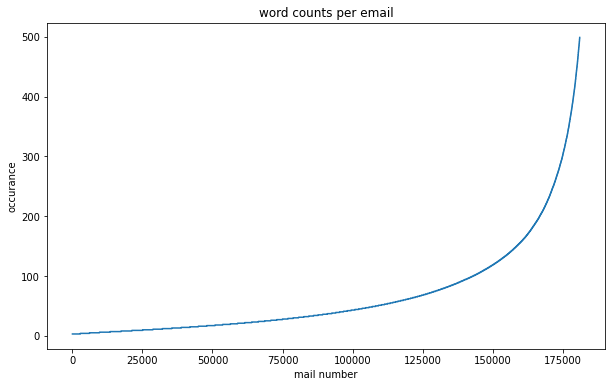

In [ ]:
#plot to show word counts per email
emails = emails[emails.word_count<500].reset_index(drop=True)
plt.figure(figsize=(10,6))
emails = emails.sort_values(by=['word_count']).reset_index(drop=True)
emails["word_count"].plot()
plt.xlabel('mail number')
plt.ylabel('occurance')
plt.title('word counts per email')
plt.show()

The emails have a word range of 3 to almost 34K words. Plotting a word count per email graph with a cap shows us that the masses are way below the word count of 500. A typical self-written email would contain and comply to a limit of approximately 125-150 words, which can also be inferred from the elbow curve of the graph. Leading us to assume that emails with more than 150 words are probably excerpts from somewhere else. Thus , removing such emails.

In [ ]:
#limiting emails to only them with <= 150 words
emails = emails[emails.word_count<=150].reset_index(drop=True)

###**Email to sentence conversion and refining**

In [ ]:
#email samples after all preprocessing till now
emails.mail_content[-5:].to_list()

['ECONOMIC CAPITAL iCONFERENCE ARCHIVE.The archives for our iConference Practical Considerations in Measuring Economic Capital are now ready.You can view the polling results.and live replay at.ECONOMIC CAPITAL REFERENCE MATERIALS.We also have assembled a list of resources on economic.Learn how economic risk relates to the problem of credit portfolio managment.Read a quick summary of the differences between various vendor models of portfolio economic capital.Read a much more detailed analysis of how portfolio models differ.Learn how some banks are using economic capital to inform their risk adjusted pricing and business line investment strategies.View two ERisk client case studies showing how economic capital measurement methodologies relate to business problems.To change your subscription preferences.please go to your account at If you have never subscribed to our services.but would like to do so.you may register at To be reminded of your password',
 'How will New Power establish credi

The above samples seems fairly clean and ready to use, except for it having some personal entities, names and is still in the form of paragraphs rather than trainable sentences.

To deal with this , we break the emails into sentences splitting them at periods('.'). To tackle the personal entities and names , we use a NER (Named entity recognition) tool to identify if the sentence has any personal names, removing those sentences which do. We also save these entity names and filter the remaining dataset in such a way that none of the sentences have any personal name or entity (This is done because sometimes the NER misses to label words even if it is a person), this is also the reason why we have'nt converted strings to lower case yet.

After removal of all the sentences with a personal touch , now the data is rudamentarily crisp and ready to use. One final step is to convert it into lower case to limit vocabulary and deduplication of sentences, to speed up the learning process and avoid redundancy.

In [ ]:
#break emails into sentences
sentences = []
for i in emails.mail_content:
  sentences.extend(i.split('.'))

clean_sent = pd.DataFrame(sentences,columns=['sentences'])

In [ ]:
#deduplication makes language models better
print("shape of clean_sent dataframe", clean_sent.shape)
print("no of duplicate sentences", clean_sent["sentences"].duplicated().sum())
clean_sent.drop_duplicates(subset = "sentences",inplace=True,ignore_index=True)
print("shape of clean_sent dataframe after removing duplicates", clean_sent.shape)

shape of clean_sent dataframe (768782, 1)
no of duplicate sentences 209156
shape of clean_sent dataframe after removing duplicates (559626, 1)


In [ ]:
#remove sentences with names/named entities
index_values=[]
names = []
for i in tqdm(range(len(clean_sent))):
  for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(clean_sent.sentences.iloc[i]))):
    if hasattr(chunk, 'label'):
      if chunk.label()=='PERSON':
          index_values.append(i)
          k = [c[0] for c in chunk]
          names.extend(k)

clean_sent = clean_sent.drop(index_values).reset_index(drop=True)

100%|██████████| 559626/559626 [40:06<00:00, 232.55it/s]


In [ ]:
#removing sentences that has names recognised by NER, refining them
#https://book.pythontips.com/en/latest/for_-_else.html#:~:text=for%20loops%20also%20have%20an,understand%20where%20to%20use%20them

names = set(names)
names = list(names)

index_values=[]
for i in tqdm(range(len(clean_sent))):
    for j in clean_sent["sentences"].iloc[i].split():
        if j in names:
            break
    else:
        index_values.append(i)

clean_sent = clean_sent.iloc[index_values].reset_index(drop=True)
print("shape of clean_sent dataframe is", clean_sent.shape)

100%|██████████| 440746/440746 [45:39<00:00, 160.89it/s]


shape of clean_sent dataframe is (231196, 1)


In [ ]:
#convert strings to lowercase
clean_sent['sentences'] = clean_sent.sentences.apply(lambda x: x.lower())

#deduplication makes language models better
print("shape of clean_sent dataframe", clean_sent.shape)
print("no of duplicate sentences", clean_sent["sentences"].duplicated().sum())
clean_sent.drop_duplicates(subset = "sentences",inplace=True,ignore_index=True)
print("shape of clean_sent dataframe after removing duplicates", clean_sent.shape)

shape of clean_sent dataframe (231196, 1)
no of duplicate sentences 1800
shape of clean_sent dataframe after removing duplicates (229396, 1)


###**Removal of rare words**

In [ ]:
#word_Tokenizer
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(clean_sent["sentences"].values)
word_counts= tokenizer.word_counts

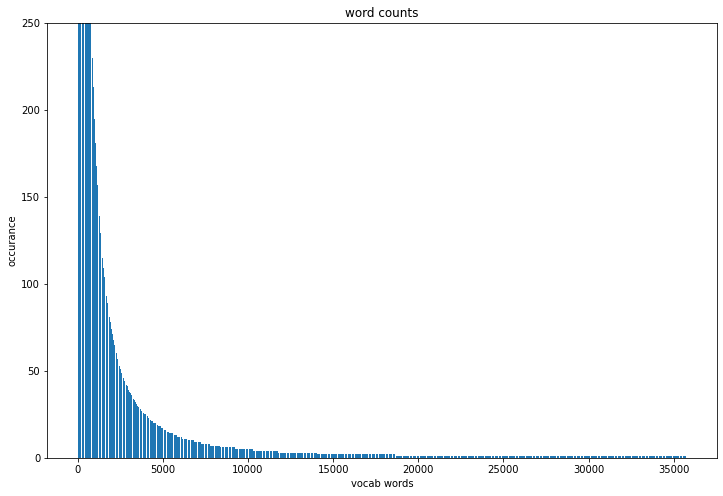

In [ ]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
word_counts_sorted = dict(sorted(word_counts.items(), key=lambda item: item[1] ,reverse=True))

#plot of words and occurances 
counts = list(word_counts_sorted.values())
words = list(word_counts_sorted.keys())
plt.figure(figsize=(12,8))
plt.bar(range(len(words)), counts)
plt.xlabel('vocab words')
plt.ylabel('occurance')
plt.title('word counts')
plt.ylim(0,250)
plt.show()

From the plot above of vocab words vs number of its occurances , we can see that it takes shape of a power law curve meaning that only a small proportion of words are used often, making other words rare.

For a language model to work efficiently , as the size of the vocab increases there is a need of exponential amount of data representing words from vocab. Thus , we limit the vocabulary to a set of words that have occured a considerable amt. of times(threshold), say 150 times here. The remaining words are considered rare because of the lack of data to represent them. 

Using the new above defined vocabulary , the dataset is much more refined to only sentences that comply with the vocab.

In [ ]:
#creating vocab with min threshold word count as 150
vocab=[]
for i,j in word_counts_sorted.items():
    if j >= 150:
        vocab.append(i)
print("final vocab size after removing the rare words ",len(vocab))

final vocab size after removing the rare words  1212


In [ ]:
#refining dataset to only sentences with words from vocab
index_values=[]
for i in range(len(clean_sent)):
    for j in clean_sent["sentences"].iloc[i].split():
        if j not in vocab:
            break
    else:
        index_values.append(i)
    
clean_sent = clean_sent.iloc[index_values].reset_index(drop=True)
print("Final shape of clean_sent dataframe is", clean_sent.shape)

Final shape of clean_sent dataframe is (84138, 1)


In [ ]:
#samples of final clean sentences
clean_sent.sentences[-30:].to_list()

['i cannot tell you how much i miss you',
 'i m home',
 'i think i have been up too long',
 'under the terms of a deal worked out over the weekend',
 'we would also end up with good as new units',
 'com and enron',
 'why dont you call them',
 'here is the last draft of the product description for gas',
 'in that now it is friday afternoon please brief me on the status of this document',
 'when should i expect to receive the next draft',
 'this was not in the first draft',
 'if we run them it will take most of the day',
 'and we may have them for the morning meeting',
 'so i may begin looking over them before our meeting on tuesday',
 'while we would be glad to assist you',
 'you can go to and order the books directly',
 'i am sorry that we cannot do this at this time',
 'continue to update',
 'or as needed',
 'but i really did not think we would hear from him again before today',
 'we enjoyed our visit also',
 'we really enjoyed your',
 'and which have not',
 'comments or concerns abou

The dataset now contains meaningful, genric sentences rid of any personal information and is constrained by a limited vocabulary, alighning it with our objective.

The final dataset contains around 85k clean, genric and often used email sentences, which is pickled(saved) for further analysis and modelling.

In [ ]:
#Pickling data
filename = 'final_data'
outfile = open(filename,'wb')
pickle.dump(clean_sent,outfile)
outfile.close()

###**EDA of final data**

We explore the clean strings to have some idea of the content, we look at word count percentiles of our corpus, the most common words(unigrams) excluding stopwords, few most common bi-grams and tri-gram phrases. This basic EDA helps us in modelling efficiently. 

In [ ]:
#retreiving data from pickle file
infile = open('final_data','rb')
clean_sent = pickle.load(infile)
infile.close()

In [ ]:
print("Total number of sentences are", len(clean_sent))

Total number of sentences are 84138


In [ ]:
#word_Counts perecentiles
word_counts = [len(re.split(' ',x)) for x in clean_sent.sentences.to_list()]
for i in range(0,103,10):
  print(i,'th percentile of number of words is', np.percentile(word_counts,i))

0 th percentile of number of words is 3.0
10 th percentile of number of words is 4.0
20 th percentile of number of words is 5.0
30 th percentile of number of words is 5.0
40 th percentile of number of words is 6.0
50 th percentile of number of words is 7.0
60 th percentile of number of words is 8.0
70 th percentile of number of words is 9.0
80 th percentile of number of words is 10.0
90 th percentile of number of words is 13.0
100 th percentile of number of words is 22.0


In [ ]:
for i in range(90,101):
  print(i,' percentile of number of words is', np.percentile(word_counts,i))

90  percentile of number of words is 13.0
91  percentile of number of words is 13.0
92  percentile of number of words is 13.0
93  percentile of number of words is 14.0
94  percentile of number of words is 14.0
95  percentile of number of words is 15.0
96  percentile of number of words is 15.0
97  percentile of number of words is 16.0
98  percentile of number of words is 17.0
99  percentile of number of words is 19.0
100  percentile of number of words is 22.0


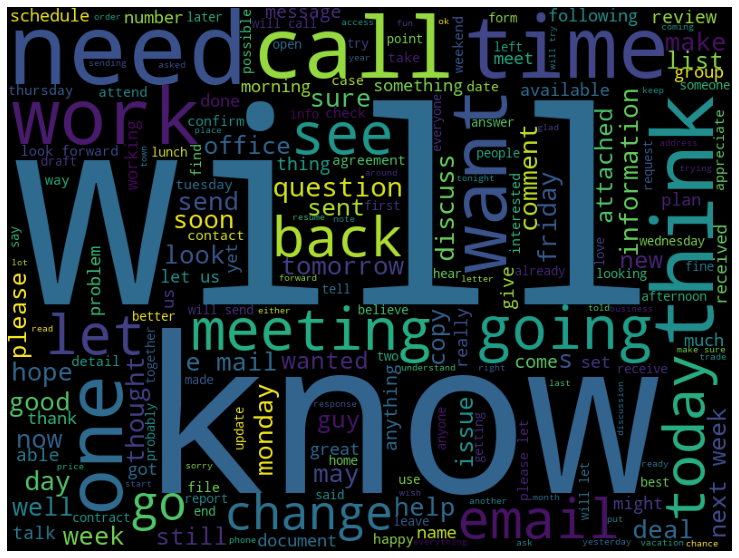

In [ ]:
#wordcloud of most common words
words = ' '.join(clean_sent.sentences.values)
wc = WordCloud(width=800,height=600,max_words=200,background_color ='black',stopwords = set(STOPWORDS)).generate(words)
plt.figure(figsize=(18,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
#most common bi-grams
cv = CountVectorizer(ngram_range=(2,2),max_features=20)   
cv_fit = cv.fit_transform(clean_sent.sentences.values)    
word_list = cv.get_feature_names_out() 
count_list = cv_fit.toarray().sum(axis=0)
bigrams = dict(zip(word_list,count_list))
bigrams_sorted = dict(sorted(bigrams.items(), key=lambda item: item[1] ,reverse=True))

for key, value in bigrams_sorted.items():
  print(key, ' : ', value)

if you  :  4614
do not  :  2884
will be  :  2614
you have  :  2105
in the  :  1967
of the  :  1930
it is  :  1903
need to  :  1710
we will  :  1580
you are  :  1567
would like  :  1536
to you  :  1519
let me  :  1442
on the  :  1435
this is  :  1426
like to  :  1392
me know  :  1379
want to  :  1309
is the  :  1250
we are  :  1213


In [ ]:
#most common tri-grams
cv = CountVectorizer(ngram_range=(3,3),max_features=20)   
cv_fit = cv.fit_transform(clean_sent.sentences.values)    
word_list = cv.get_feature_names_out() 
count_list = cv_fit.toarray().sum(axis=0)
trigrams = dict(zip(word_list,count_list))
trigrams_sorted = dict(sorted(trigrams.items(), key=lambda item: item[1] ,reverse=True))

for key, value in trigrams_sorted.items():
  print(key, ' : ', value)

let me know  :  1375
would like to  :  1202
if you have  :  1183
you have any  :  684
do not know  :  644
let you know  :  536
do not have  :  501
look forward to  :  484
be able to  :  477
as soon as  :  470
if you are  :  461
we need to  :  457
please let me  :  443
if you need  :  441
have any questions  :  422
here is the  :  421
will let you  :  382
you would like  :  378
if you would  :  367
me know if  :  364


##**Modelling**

In [1]:
#Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import email
import re
import nltk
from tqdm import tqdm
import pickle
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import matplotlib.ticker as ticker
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from prettytable import PrettyTable
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, GRU, Attention,concatenate

In [2]:
#retreiving data from pickle file
infile = open('final_data','rb')
clean_sent = pickle.load(infile)
infile.close()

In [3]:
#retreiving embeddings from pickle file
infile = open('embeddings_index','rb')
embeddings_index = pickle.load(infile)
infile.close()

###**Performance metrics**

1. **BLEU score**: BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a
generated sentence with a referenced one. A perfect match results in a score of 1.0,
whereas a perfect mismatch results in a score of 0.0. In the task of sentence prediction, it
helps us evaluate how closely a predicted sentence is, to the one that’s expected. This is
achieved by counting matching n-grams in the predicted to n-grams in the reference text,
where 1-gram or unigram would be each token and a bigram comparison would be each
word pair. The comparison is made regardless of word order.

In [4]:
#BLEU_score
def bleuscore(org, pred):
  """returns BLEU Score"""
  org_tokens = org.split()
  pred_tokens = pred.split()
  score = nltk.translate.bleu_score.sentence_bleu([org_tokens], pred_tokens,weights = (1,0))
  return score

2. **Perplexity**: Perplexity is a metric used to judge how good a language model is .We can
define perplexity as the inverse probability of the test set, normalised by the number of
words.
 
 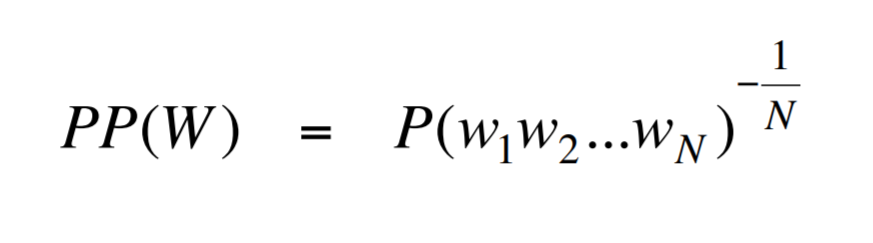

 we can interpret perplexity as the weighted branching factor. If we have a perplexity of
100, it means that whenever the model is trying to guess the next word it is as confused
as if it had to pick between 100 words, i.e. lesser the perplexity, better the language
model.

In [5]:
#perplexity
#https://stackoverflow.com/questions/56328140/how-do-i-implement-a-masked-softmax-cross-entropy-loss-function-in-keras

def perplexity(y_true, y_pred):
    """gets perplexity values accounting for masked values too"""
    y_true_masked = tf.boolean_mask(y_true, tf.not_equal(y_true, 0))
    y_pred_masked = tf.boolean_mask(y_pred, tf.not_equal(y_true, 0))
    return K.exp(K.sum(K.sparse_categorical_crossentropy(y_true_masked, y_pred_masked))/(1024*22))

In [6]:
#perplexity for attention model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def perplexity_attn(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.exp(tf.reduce_mean(loss_))

###**Data Preperation**

Once we have preprocessed the dataset, the next step would be modelling. In order to do that we have to prepare the data for training. This involves the train-test split and formatting the data to a form that a model can interpret, process and train on efficiently.

In this context, since the seq2seq approaches we are using here tend to convolve around a Reccurent neural network, It is quite prominent that we see the enforcement of teacher forcing method involved in the training process.

Teacher forcing is a strategy for training recurrent neural networks that uses ground truth as input, instead of model output from a prior time step as an input. It helps in converging faster, limiting training time. Thus , we prepare the data in accordance to teacher forcing.



In [7]:
#train-validation split
train, validation = train_test_split(clean_sent,test_size=0.2,random_state=69,shuffle=True)
print('shape of train data', train.shape)
print('shape of validation data', validation.shape)

shape of train data (67310, 1)
shape of validation data (16828, 1)


In [8]:
#data_preparation (train)
data = []
for sent in train.sentences:
  tokens = sent.split()
  for i in range(len(tokens)-1):
    input_encoder  = '<start> ' + ' '.join(tokens[:i+1]) + ' <end>'
    input_decoder  = '<start> ' + ' '.join(tokens[i+1:]) 
    output_decoder = ' '.join(tokens[i+1:]) + ' <end>'
    data.append([input_encoder,input_decoder,output_decoder])

train_data = pd.DataFrame(data,columns=['input_encoder','input_decoder','output_decoder'])
train_data.head()

,input_encoder,input_decoder,output_decoder
0,<start> for <end>,<start> many years,many years <end>
1,<start> for many <end>,<start> years,years <end>
2,<start> i <end>,<start> am trying to update our physical confi...,am trying to update our physical confirms but ...
3,<start> i am <end>,<start> trying to update our physical confirms...,trying to update our physical confirms but am ...
4,<start> i am trying <end>,<start> to update our physical confirms but am...,to update our physical confirms but am missing...


In [9]:
#data_preparation (validation)
data = []
for sent in validation.sentences:
  tokens = sent.split()
  for i in range(len(tokens)-1):
    input_encoder  = '<start> ' + ' '.join(tokens[:i+1]) + ' <end>'
    input_decoder  = '<start> ' + ' '.join(tokens[i+1:]) 
    output_decoder = ' '.join(tokens[i+1:]) + ' <end>'
    data.append([input_encoder,input_decoder,output_decoder])

validation_data = pd.DataFrame(data,columns=['input_encoder','input_decoder','output_decoder'])
validation_data.head()

,input_encoder,input_decoder,output_decoder
0,<start> you <end>,<start> will do a great job,will do a great job <end>
1,<start> you will <end>,<start> do a great job,do a great job <end>
2,<start> you will do <end>,<start> a great job,a great job <end>
3,<start> you will do a <end>,<start> great job,great job <end>
4,<start> you will do a great <end>,<start> job,job <end>


In [10]:
print('shape of train data', train_data.shape)
print('shape of validation data', validation_data.shape)

shape of train data (455512, 3)
shape of validation data (113943, 3)


Here , we are using words as tokens.

Since our objective is to complete sentences from initial parts of it, the input would be partial sentences and the output should be the other part of the sentence that completes it.

After splitting the data for train and validation, to prepare the data in accordance to teacher forcing we add a '\<start\>' and '\<end\>' token to the input at the start and end of the sentence respectively, these inputs go to the encoder part of the model i.e. we call them encoder inputs. These are the parts of sentences on the basis of which the model tries to and completes it.

For the decoder part of the model, teacher forcing involves passage of target word as the next input to the decoder i.e. decoder inputs have a '\<start\>' token as their initial input and decoder outputs have an '\<end\>' token to signal the ending. In the training phase, the content of both decoder inputs and outputs are same except for the additional tokens added, it is the remaining part of the sentence that the model is trained to predict.

Next step is tokenization and padding of sequences before finally using it for model training.

In [11]:
#defining tokenizer vocab
train.sentences.iloc[0] = str('<start> ') + str(train.sentences.iloc[0]) + str(' <end>') #adding start and end tokens to vocab

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='<oov>')
tokenizer.fit_on_texts(train['sentences'].values)
vocab_size = len(tokenizer.word_index.items())
print("vocab size including start, end and oov tokens is",vocab_size)

vocab size including start, end and oov tokens is 1215


In [12]:
#embedding matrix
word_index = tokenizer.word_index

vocab_size=len(word_index)+1
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
#creating index to word dictionary
index_word={}
for key,value in tokenizer.word_index.items():
  index_word[value]=key 

In [14]:
#okenization and padding function
def token_pad(data):
  """ tokenizes and pads the sequence"""
  input_encoder  = tokenizer.texts_to_sequences(data.input_encoder)
  input_decoder  = tokenizer.texts_to_sequences(data.input_decoder)
  output_decoder = tokenizer.texts_to_sequences(data.output_decoder)

  input_encoder  = pad_sequences(input_encoder, maxlen=max_len_encoder, padding='post')
  input_decoder  = pad_sequences(input_decoder, maxlen=max_len_decoder, padding='post')
  output_decoder = pad_sequences(output_decoder, maxlen=max_len_decoder, padding='post')

  return input_encoder,input_decoder,output_decoder

In [15]:
#final sequences
max_len_encoder = (22-1) + 2 #maxlength of whole sentence is 22
max_len_decoder = (22-1) + 1

input_encoder_tr, input_decoder_tr, output_decoder_tr = token_pad(train_data)
input_encoder_val, input_decoder_val, output_decoder_val = token_pad(validation_data)

###**Base Model (LSTM)**

In [ ]:
#defining parameters
vocab_len = vocab_size 
embedding_size = 300
lstm_units = 128
batch_size = 1024
epochs = 18

In [ ]:
#LSTM encoder-decoder model

#encoder
input_layer_en  = Input(shape = (max_len_encoder,))
embedd_layer_en = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_encoder, 
                            mask_zero=True)
lstm_layer_en   = LSTM(units=lstm_units, return_state=True, return_sequences=True)

encoder_out, en_state_h, en_state_c = lstm_layer_en(embedd_layer_en(input_layer_en))
states = [en_state_h, en_state_c]

#decoder
input_layer_dec  = Input(shape = (max_len_decoder,))
embedd_layer_dec = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_decoder, 
                            mask_zero=True)
lstm_layer_dec   = LSTM(units=lstm_units, return_state=True, return_sequences=True)

decoder_out, _, _ = lstm_layer_dec(embedd_layer_dec(input_layer_dec), initial_state=states)

#dense layer
dense_layer = Dense(vocab_len, activation='softmax')

output = dense_layer(decoder_out)

#model definition
lstm_model = Model([input_layer_en, input_layer_dec], output)
optimizer  = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[perplexity])

lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 23, 300)      364800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 22, 300)      364800      ['input_2[0][0]']                
                                                                                              

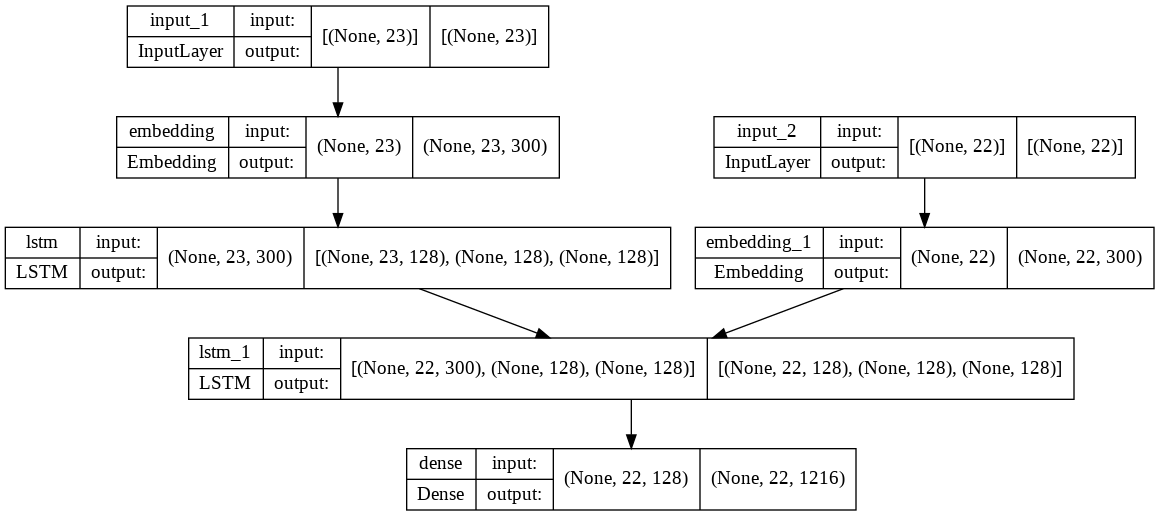

In [ ]:
#plotting model
plot_model(lstm_model, "lstm_model.png", show_shapes=True)

In [ ]:
#model fitting
earlystop = EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)

lstm_history = lstm_model.fit([input_encoder_tr, input_decoder_tr], output_decoder_tr, batch_size=batch_size,
                 epochs=epochs, validation_data=([input_encoder_val, input_decoder_val], output_decoder_val),
                 callbacks=[earlystop])

Epoch 1/18
445/445 [==============================] - 32s 46ms/step - loss: 1.2225 - perplexity: 3.4389 - val_loss: 1.0590 - val_perplexity: 2.8888
Epoch 2/18
445/445 [==============================] - 19s 42ms/step - loss: 1.0003 - perplexity: 2.7205 - val_loss: 0.9730 - val_perplexity: 2.6506
Epoch 3/18
445/445 [==============================] - 18s 41ms/step - loss: 0.9330 - perplexity: 2.5431 - val_loss: 0.9307 - val_perplexity: 2.5407
Epoch 4/18
445/445 [==============================] - 19s 43ms/step - loss: 0.8891 - perplexity: 2.4336 - val_loss: 0.9054 - val_perplexity: 2.4772
Epoch 5/18
445/445 [==============================] - 19s 42ms/step - loss: 0.8578 - perplexity: 2.3584 - val_loss: 0.8893 - val_perplexity: 2.4375
Epoch 6/18
445/445 [==============================] - 19s 42ms/step - loss: 0.8337 - perplexity: 2.3022 - val_loss: 0.8796 - val_perplexity: 2.4140
Epoch 7/18
445/445 [==============================] - 19s 43ms/step - loss: 0.8137 - perplexity: 2.2570 - val_lo

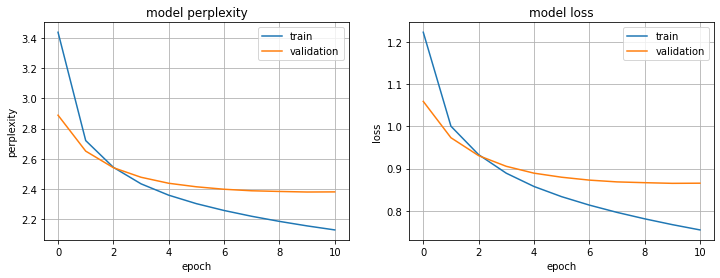

In [ ]:
#plotting loss and metric values
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['perplexity'])
plt.plot(lstm_history.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.show()

In [ ]:
#function using trainned lstm_model to predict sentences
def predict_lstm(input_sentence):
    """function to get the predicted sentences"""
    encoder_seq = tokenizer.texts_to_sequences([input_sentence])
    encoder_seq = pad_sequences(encoder_seq, maxlen=max_len_encoder, padding='post')
    encoder_out, en_state_h, en_state_c = lstm_model.layers[4](lstm_model.layers[2](lstm_model.layers[0](encoder_seq)))
    states = [en_state_h, en_state_c]
    dec_input = np.zeros((1,1))
    dec_input[0,0] = tokenizer.word_index['<start>']
    stop_condition=False
    sent=''
    
    while not stop_condition:
        predicted_out, state_h, state_c = lstm_model.layers[5](lstm_model.layers[3](lstm_model.layers[1](dec_input)),initial_state=states)
        dense_out = lstm_model.layers[6](predicted_out)
        states = [state_h, state_c]
        output = np.argmax(dense_out)
        dec_input = np.reshape(output, (1, 1))
        if index_word[output] == '<end>':
            stop_condition=True
        else:
            sent=sent + ' ' + index_word[output]

    return sent

In [ ]:
#predictions on some common phrases encountered
phrases = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'give her',
    'i will let',
    'may i get a copy',
    'how is',
    'this looks like',
    'i am',
    'please'
]

for i in phrases:
  input = '<start> '+ i +' <end>'
  predicted = predict_lstm(input)
  print('Input ---->' , i)
  print('Predict ---->', predicted)
  print('=='*30)

Input ----> here is
Predict ---->  the latest version of the contract
Input ----> please review
Predict ---->  the attached and send it to you
Input ----> thanks for
Predict ---->  your help
Input ----> let me
Predict ---->  know if you have any questions or concerns
Input ----> Let me know if you
Predict ---->  have any questions
Input ----> can you get
Predict ---->  a copy
Input ----> is it okay
Predict ---->  with you
Input ----> it should
Predict ---->  be a good idea to get a copy of the agreement
Input ----> call if there is
Predict ---->  anything else i can do to help
Input ----> give her
Predict ---->  a call
Input ----> i will let
Predict ---->  you know when i get back to you
Input ----> may i get a copy
Predict ---->  of the agreement
Input ----> how is
Predict ---->  the same
Input ----> this looks like
Predict ---->  a good time
Input ----> i am
Predict ---->  not sure if you have any questions or concerns
Input ----> please
Predict ---->  let me know if you have any que

In [ ]:
#calculating avg BLEU score for lstm_model

bleu=[]
validation = validation_data.sample(1600, random_state=41)
for i in tqdm(range(len(validation))):
  org = validation['output_decoder'].iloc[i][:-6]
  pred = predict_lstm(validation['input_encoder'].iloc[i])
  score = bleuscore(org, pred)
  bleu.append(score)

print('bleuscore is',np.mean(bleu))

100%|██████████| 1600/1600 [01:04<00:00, 24.79it/s]

bleuscore is 0.12397006698784914


###**Bi-directional GRU**

In [ ]:
#defining parameters
vocab_len = vocab_size 
embedding_size = 300
gru_units = 128
batch_size = 1024
epochs = 10

In [ ]:
#Bi-directional GRU encoder-decoder model

#encoder
input_layer_en  = Input(shape = (max_len_encoder,))
embedd_layer_en = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_encoder,
                            mask_zero=True)
bigru_layer_en  = Bidirectional(GRU(units=gru_units, return_state=True, return_sequences=True))

encoder_out, fw_state_h, ba_state_h = bigru_layer_en(embedd_layer_en(input_layer_en))
en_state_h = Concatenate()([fw_state_h, ba_state_h])

#decoder
input_layer_dec  = Input(shape = (max_len_decoder,))
embedd_layer_dec = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_decoder, 
                            mask_zero=True)
bigru_layer_dec   = GRU(units=gru_units*2, return_state=True, return_sequences=True)

decoder_out, _ = bigru_layer_dec(embedd_layer_dec(input_layer_dec), initial_state=en_state_h)

#dense layer
dense_layer = Dense(vocab_len, activation='softmax')

output = dense_layer(decoder_out)

#model definition
bigru_model = Model([input_layer_en, input_layer_dec], output)
optimizer  = Adam(learning_rate=0.001)
bigru_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[perplexity])

bigru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 23, 300)      364800      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 23, 256),    330240      ['embedding_2[0][0]']            
                                 (None, 128),                                               

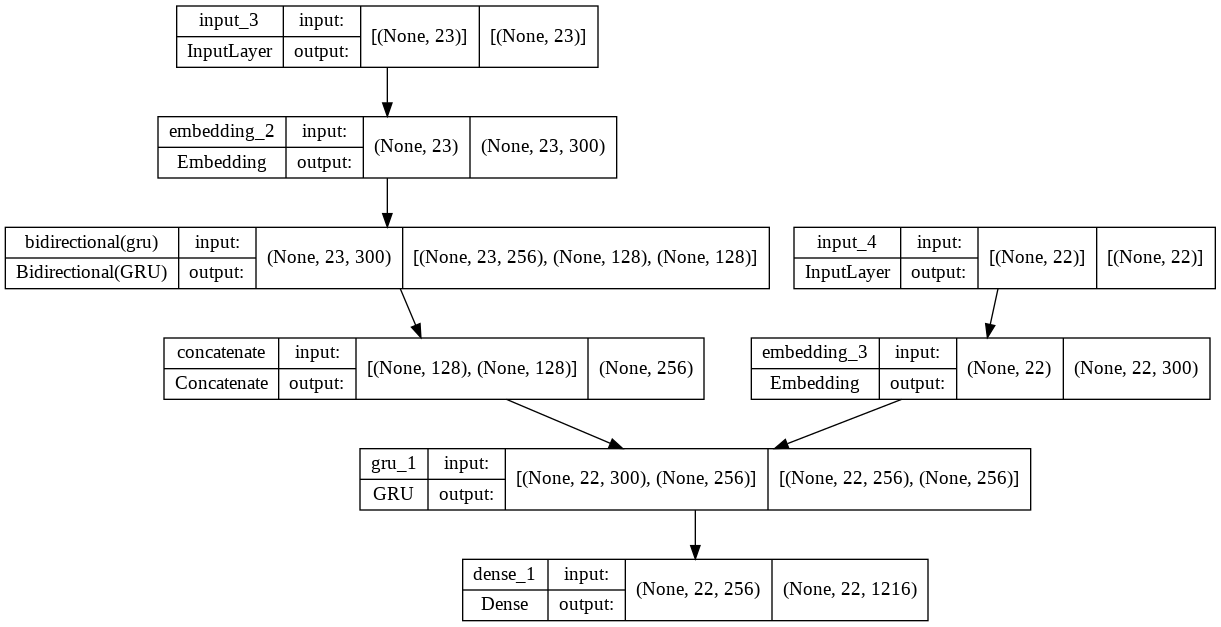

In [ ]:
#plotting model
plot_model(bigru_model, "bigru_model.png", show_shapes=True)

In [ ]:
#model fitting
earlystop = EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)

bigru_history = bigru_model.fit([input_encoder_tr, input_decoder_tr], output_decoder_tr, batch_size=batch_size,
                 epochs=epochs, validation_data=([input_encoder_val, input_decoder_val], output_decoder_val),
                 callbacks=[earlystop])

Epoch 1/10
445/445 [==============================] - 40s 67ms/step - loss: 1.0771 - perplexity: 2.9904 - val_loss: 0.9265 - val_perplexity: 2.5300
Epoch 2/10
445/445 [==============================] - 27s 60ms/step - loss: 0.8560 - perplexity: 2.3550 - val_loss: 0.8688 - val_perplexity: 2.3881
Epoch 3/10
445/445 [==============================] - 26s 60ms/step - loss: 0.7873 - perplexity: 2.1980 - val_loss: 0.8531 - val_perplexity: 2.3508
Epoch 4/10
445/445 [==============================] - 27s 60ms/step - loss: 0.7410 - perplexity: 2.0983 - val_loss: 0.8515 - val_perplexity: 2.3471
Epoch 5/10
445/445 [==============================] - 27s 60ms/step - loss: 0.7051 - perplexity: 2.0243 - val_loss: 0.8565 - val_perplexity: 2.3589


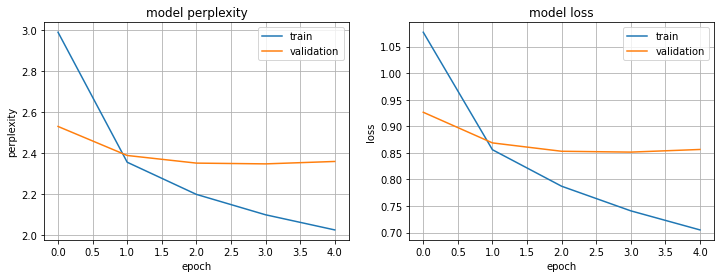

In [ ]:
#plotting loss and metric values
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(bigru_history.history['perplexity'])
plt.plot(bigru_history.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(bigru_history.history['loss'])
plt.plot(bigru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.show()

In [ ]:
#function using trainned bigru_model to predict sentences
def predict_gru(input_sentence):
    """function to get the predicted sentences"""
    encoder_seq = tokenizer.texts_to_sequences([input_sentence])
    encoder_seq = pad_sequences(encoder_seq, maxlen=max_len_encoder, padding='post')
    encoder_out, fw_state_h, ba_state_h = bigru_model.layers[3](bigru_model.layers[1](bigru_model.layers[0](encoder_seq)))
    state_h = Concatenate()([fw_state_h, ba_state_h])
    dec_input = np.zeros((1,1))
    dec_input[0,0] = tokenizer.word_index['<start>']
    stop_condition=False
    sent=''
    
    while not stop_condition:
        predicted_out, state_h = bigru_model.layers[6](bigru_model.layers[4](bigru_model.layers[2](dec_input)),initial_state=state_h)
        dense_out = bigru_model.layers[7](predicted_out)
        output = np.argmax(dense_out)
        dec_input = np.reshape(output, (1, 1))
        if index_word[output] == '<end>':
            stop_condition=True
        else:
            sent=sent + ' ' + index_word[output]

    return sent

In [ ]:
#predictions on some common phrases encountered
phrases = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'give her',
    'i will let',
    'may i get a copy',
    'how is',
    'this looks like',
    'i am',
    'please'
]

for i in phrases:
  input = '<start> '+ i +' <end>'
  predicted = predict_gru(input)
  print('Input ---->' , i)
  print('Predict ---->', predicted)
  print('=='*30)

Input ----> here is
Predict ---->  the latest version of the presentation
Input ----> please review
Predict ---->  the attached document
Input ----> thanks for
Predict ---->  your help
Input ----> let me
Predict ---->  know if you have any questions
Input ----> Let me know if you
Predict ---->  have any questions
Input ----> can you get
Predict ---->  a copy
Input ----> is it okay
Predict ---->  with the
Input ----> it should
Predict ---->  be a good idea
Input ----> call if there is
Predict ---->  anything else i can do to help
Input ----> give her
Predict ---->  a call
Input ----> i will let
Predict ---->  you know when i hear from him
Input ----> may i get a copy
Predict ---->  of the agreement
Input ----> how is
Predict ---->  the day
Input ----> this looks like
Predict ---->  the first time
Input ----> i am
Predict ---->  not sure what to do
Input ----> please
Predict ---->  let me know if you have any questions


In [ ]:
#calculating avg BLEU score for Gru_model

bleu=[]
validation = validation_data.sample(1600, random_state=41)
for i in tqdm(range(len(validation))):  
  org = validation['output_decoder'].iloc[i][:-6]
  pred = predict_gru(validation['input_encoder'].iloc[i])
  score = bleuscore(org, pred)
  bleu.append(score)

print('bleuscore is',np.mean(bleu))

100%|██████████| 1600/1600 [01:10<00:00, 22.60it/s]

bleuscore is 0.130909106590213


###**Bi-Directional GRU with attention**

In [ ]:
#defining parameters
vocab_len = vocab_size 
embedding_size = 300
gru_units = 128
attn_units = 128*2
batch_size = 1024
epochs = 10

In [ ]:
#loss function for attention model
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
#defining attention layer
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score using Bahdanu attention mechanism.
  '''
  def __init__(self, attn_units):
    super(Attention, self).__init__()
    self.attn_units=attn_units
    
  def call(self,decoder_hidden_state,encoder_output):
    decoder_state = tf.expand_dims(decoder_hidden_state,1)
    score = tf.matmul(encoder_output,decoder_state,transpose_b=True)
    attention_weights = tf.nn.softmax(score,axis=1)
    context = attention_weights*encoder_output
    context_vector = tf.reduce_sum(context,axis=1)
        
    return context_vector,attention_weights

In [ ]:
#defining one step decoder for attention model
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_len, embedding_size,max_len_decoder, gru_units ,attn_units):
    super(One_Step_Decoder, self).__init__()
    
    self.embedding = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_decoder,
                                   mask_zero=True)
    self.gru = GRU(gru_units*2, return_state=True, return_sequences=True)
    self.attention= Attention(attn_units)
    self.dense= Dense(vocab_len)

  def call(self, input_to_decoder, encoder_output, en_state_h):
    
    embedding_output = self.embedding(input_to_decoder)
    context_vector, attention_weights = self.attention(en_state_h,encoder_output)
    concatt = concatenate([tf.expand_dims(context_vector,axis=1),embedding_output])
    gru_output, gru_state_h = self.gru(concatt,initial_state=en_state_h)
    gru_output = tf.squeeze(gru_output,axis=1)
    decoder_output = self.dense(gru_output)
    
    return decoder_output,gru_state_h,attention_weights,context_vector

In [ ]:
#defining decoder using one step decoder
class Decoder(tf.keras.Model):
    def __init__(self,vocab_len, embedding_size, max_len_decoder, gru_units ,attn_units):
        super(Decoder, self).__init__()
        
        self.onestepdecoder=One_Step_Decoder(vocab_len,embedding_size,max_len_decoder,gru_units,attn_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):
        
        all_outputs= tf.TensorArray(tf.float32,size=tf.shape(input_to_decoder)[1])
        
        for timestep in range(tf.shape(input_to_decoder)[1]):
            output,decoder_hidden_state,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                                        encoder_output,
                                                                                        decoder_hidden_state)
            all_outputs=all_outputs.write(timestep,output)
        
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [ ]:
#Bi-directional GRU encoder-decoder model with attention

#encoder
input_layer_en  = Input(shape = (max_len_encoder,))
embedd_layer_en = Embedding(input_dim=vocab_len, output_dim=embedding_size, weights=[embedding_matrix], input_length=max_len_encoder,
                            mask_zero=True)
bigru_layer_en  = Bidirectional(GRU(units=gru_units, return_state=True, return_sequences=True))

encoder_out, fw_state_h, ba_state_h = bigru_layer_en(embedd_layer_en(input_layer_en))
en_state_h = Concatenate()([fw_state_h, ba_state_h])

#decoder
input_layer_dec  = Input(shape = (max_len_decoder,))
decoder_layer    = Decoder(vocab_len, embedding_size, max_len_decoder, gru_units ,attn_units)
decoder_output   = decoder_layer(input_layer_dec,encoder_out,en_state_h)

#model definition
bigru_attn_model = Model([input_layer_en, input_layer_dec], decoder_output)
optimizer  = Adam(learning_rate=0.001)
bigru_attn_model.compile(optimizer=optimizer, loss=loss_function, metrics=[perplexity_attn])

bigru_attn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 23, 300)      364800      ['input_5[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 23, 256),   330240      ['embedding_4[0][0]']            
 )                               (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
#model fitting
earlystop = EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)

bigru_attn_history = bigru_attn_model.fit([input_encoder_tr, input_decoder_tr], output_decoder_tr, batch_size=batch_size,
                 epochs=epochs, validation_data=([input_encoder_val, input_decoder_val], output_decoder_val),
                 callbacks=[earlystop])

Epoch 1/10
445/445 [==============================] - 164s 343ms/step - loss: 1.1001 - perplexity_attn: 3.0513 - val_loss: 0.9477 - val_perplexity_attn: 2.5810
Epoch 2/10
445/445 [==============================] - 170s 383ms/step - loss: 0.8830 - perplexity_attn: 2.4191 - val_loss: 0.8898 - val_perplexity_attn: 2.4355
Epoch 3/10
445/445 [==============================] - 152s 341ms/step - loss: 0.8184 - perplexity_attn: 2.2674 - val_loss: 0.8699 - val_perplexity_attn: 2.3874
Epoch 4/10
445/445 [==============================] - 153s 345ms/step - loss: 0.7749 - perplexity_attn: 2.1708 - val_loss: 0.8635 - val_perplexity_attn: 2.3724
Epoch 5/10
445/445 [==============================] - 149s 335ms/step - loss: 0.7396 - perplexity_attn: 2.0954 - val_loss: 0.8640 - val_perplexity_attn: 2.3736


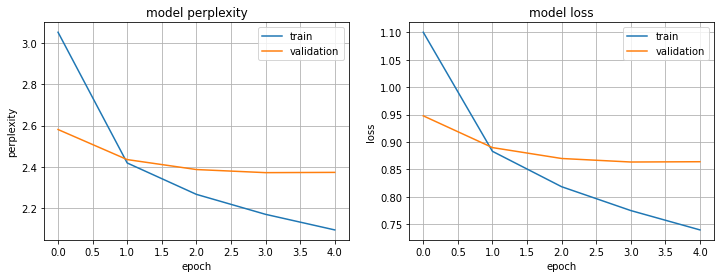

In [ ]:
#plotting loss and metric values
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(bigru_attn_history.history['perplexity_attn'])
plt.plot(bigru_attn_history.history['val_perplexity_attn'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(bigru_attn_history.history['loss'])
plt.plot(bigru_attn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

plt.show()

In [ ]:
#attention plots function
def plot_attention(attention,original,predicted):
  """function for attention plots"""
  org=original.split()
  pred=predicted.split()
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', vmin=0.0)
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + org, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + pred, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')
  plt.imshow(attention, vmin=0.0)

In [ ]:
#function using trainned bigru_model to predict sentences
def predict_gru_attn(input_sentence,attn_plot=False):
    """function to get the predicted sentences"""
    encoder_seq = tokenizer.texts_to_sequences([input_sentence])
    encoder_seq = pad_sequences(encoder_seq, maxlen=max_len_encoder, padding='post')
    encoder_out, fw_state_h, ba_state_h = bigru_attn_model.layers[2](bigru_attn_model.layers[1](bigru_attn_model.layers[0](encoder_seq)))
    state_h = Concatenate()([fw_state_h, ba_state_h])
    dec_input = np.zeros((1,1))
    dec_input[0,0] = tokenizer.word_index['<start>']
    stop_condition=False
    attention = []
    sent=''
    
    while not stop_condition:
        predictions, state_h, attention_weights, context_vector = bigru_attn_model.layers[5].onestepdecoder(dec_input, encoder_out, state_h)
        output=np.argmax(predictions)
        dec_input=np.reshape(output, (1, 1))
        if index_word[output]=='<end>':
            stop_condition=True
        else:
            sent=sent+' '+index_word[output]
            if attn_plot:
              aw = np.squeeze(attention_weights)
              attention.append(aw[:len(input_sentence.split())])
    
    if attn_plot:
      plot_attention(attention,input_sentence,sent)
      
    return sent

In [ ]:
#predictions on some common phrases encountered
phrases = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'give her',
    'i will let',
    'may i get a copy',
    'how is',
    'this looks like',
    'i am',
    'please'
]

for i in phrases:
  input = '<start> '+ i +' <end>'
  predicted = predict_gru_attn(input)
  print('Input ---->' , i)
  print('Predict ---->', predicted)
  print('=='*30)

Input ----> here is
Predict ---->  the latest version of the contract
Input ----> please review
Predict ---->  the attached
Input ----> thanks for
Predict ---->  your help
Input ----> let me
Predict ---->  know if you need anything else
Input ----> Let me know if you
Predict ---->  have any questions or concerns
Input ----> can you get
Predict ---->  a copy of the agreement
Input ----> is it okay
Predict ---->  with me
Input ----> it should
Predict ---->  be a good time to meet you
Input ----> call if there is
Predict ---->  any questions or concerns
Input ----> give her
Predict ---->  a call
Input ----> i will let
Predict ---->  you know when i hear from you
Input ----> may i get a copy
Predict ---->  of the agreement
Input ----> how is
Predict ---->  the game
Input ----> this looks like
Predict ---->  it is a good idea
Input ----> i am
Predict ---->  not sure what you are looking for
Input ----> please
Predict ---->  let me know if you have any questions or concerns


In [ ]:
#calculating avg BLEU score for Gru_model with attention
bleu=[]
validation = validation_data.sample(1600,random_state=41)
for i in tqdm(range(len(validation))):
  org = validation['output_decoder'].iloc[i][:-6]
  pred = predict_gru_attn(validation['input_encoder'].iloc[i])
  score = bleuscore(org, pred)
  bleu.append(score)

print('bleuscore is',np.mean(bleu))

100%|██████████| 1600/1600 [01:32<00:00, 17.35it/s]

bleuscore is 0.1291251724541413


' any questions or concerns'

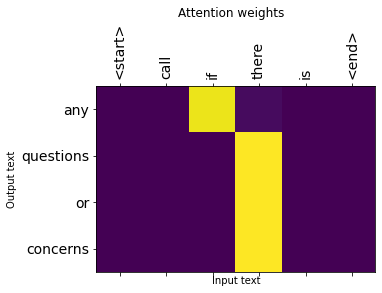

In [ ]:
#few attention plots
predict_gru_attn('<start> call if there is <end>',attn_plot=True)

' you know when i hear from you'

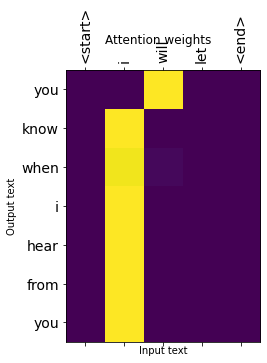

In [ ]:
predict_gru_attn('<start> i will let <end>',attn_plot=True)

###**Results**

In [ ]:
#results summary on val data
myTable = PrettyTable([ "Model", "best loss", "best perplexity", "Bleu Score"])
  
myTable.add_row(["Forward only LSTM", "0.8652", "2.3795", "0.1239"])
myTable.add_row(["Bidirectional GRU", "0.8515", "2.3471", "0.1309"])
myTable.add_row(["Bidirectional GRU with attention", "0.8635", "2.3724", "0.1291"])
               
print(myTable)

+----------------------------------+-----------+-----------------+------------+
|              Model               | best loss | best perplexity | Bleu Score |
+----------------------------------+-----------+-----------------+------------+
|        Forward only LSTM         |   0.8652  |      2.3795     |   0.1239   |
|        Bidirectional GRU         |   0.8515  |      2.3471     |   0.1309   |
| Bidirectional GRU with attention |   0.8635  |      2.3724     |   0.1291   |
+----------------------------------+-----------+-----------------+------------+


In conclusion to our experimentation with modelling, we can see that all the language models that we have trained have a similar performance with slight variation in their metrics. This is mostly accredited to the detailed and meticulous cleaning and preprocessing of data into genric sentences.

Bi-Directional GRU model seems to give the best results, i.e. making it the best model.

Since , this is a genric language prediction task and not a language translation problem, the bleu score tends to feel low. Here, we are not trying to exactly replicate the sentences. A much higher BLEU score for this task would indicate that we are overfitting on the train dataset.

##**Beam Search**

Beam search is an algorithm used in many NLP and speech recognition models as a final decision making layer to choose the best output given target variables like maximum probability or next output character. It considers k such options at every time step to finally get the most probablistic sentence. Although it is computaionally and timely expensive, it tends to give much better and meaningful outputs.

Below implemented is a custom beam search algorithm for the best model from above (bi-directional GRU encoder-decoder model).
The below algorithm gives us flexibilty in choosing parameters such as max_len of the recommendations, number of suggestions and the beam width(k). although slightly time taking, it tends to provide much better suggestions.

With some trial and error, i have noticed that it provides the best suggestions optimally with a max_len range of 10-15 words, beam width between 3 to 5 and no_suggestions in a similar range.

In [ ]:
#retreiving bi-directional GRU model
infile = open('bigru_model','rb')
bigru_model = pickle.load(infile)
infile.close()

In [ ]:
#beam search for bi-GRU model
def beam_search(input_sentence,k=3,max_len=12,no_suggestions=3):
    """function to get the predicted sentences"""

    start_token = tokenizer.word_index['<start>']
    end_token   = tokenizer.word_index['<end>']

    #encoding part
    encoder_seq = tokenizer.texts_to_sequences([input_sentence])
    encoder_seq = pad_sequences(encoder_seq, maxlen=max_len_encoder, padding='post')
    encoder_out, fw_state_h, ba_state_h = bigru_model.layers[3](bigru_model.layers[1](bigru_model.layers[0](encoder_seq)))
    states = Concatenate()([fw_state_h, ba_state_h])

    #variable declaration
    eos_sent = []
    eosent_score = []
    top_ksent = [[start_token]]
    top_kscore = [0]
    counter = 0

    #beam_search loop
    while counter<max_len: 
      temp_sent  = []
      temp_score = []
      counter += 1
      for i,sent in enumerate(top_ksent):
        state_h = states
        for j in range(len(sent)):
          dec_input = np.reshape(sent[j],(1,1))
          predicted_out, state_h = bigru_model.layers[6](bigru_model.layers[4](bigru_model.layers[2](dec_input)),initial_state=state_h)      
        score_0 = bigru_model.layers[7](predicted_out)[0,0,:]
        top_k0 = (np.argsort(score_0)[::-1][:k]).tolist()
        k_scores = np.log((np.sort(score_0)[::-1][:k])).tolist()
        if end_token in top_k0:
          eos_sent.append([*sent,end_token])
          eosent_score.append((top_kscore[i]+k_scores[top_k0.index(end_token)])/2)
          del k_scores[top_k0.index(end_token)]
          del top_k0[top_k0.index(end_token)]
        temp_sent.extend([[*sent,m] for m in top_k0])
        temp_score.extend([(m+top_kscore[i])/2 for m in k_scores])
    
      top_ksent =  [temp_sent[l] for l in (np.argsort(temp_score)[::-1][:k]).tolist()]
      top_kscore = (np.sort(temp_score)[::-1][:k]).tolist()

    #tokens to sentence conversion
    eos_index = (np.argsort(eosent_score)[::-1][:no_suggestions]).tolist()
    eos_sent = [eos_sent[h] for h in eos_index]
    eosent_score = (np.sort(eosent_score)[::-1][:no_suggestions]).tolist()
    
    best_sentences = []
    for p,sentence in enumerate(eos_sent):
      best_sent = ''
      for word in sentence[1:-1]:
        best_sent += ' ' + index_word[word]
      best_sentences.append([best_sent,eosent_score[p]])
    
    return best_sentences

In [ ]:
#predictions on some common phrases encountered
phrases = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'give her',
    'i will let',
    'may i get a copy',
    'how is',
    'this looks like',
    'i am',
    'please'
]

for i in phrases:
  input = '<start> '+ i +' <end>'
  predicted = beam_search(input)
  print('Input ---->' , i)
  print('Predict ---->', predicted)
  print('=='*30)

Input ----> here is
Predict ----> [[' the latest version of the deal', -0.8360011973418295], [' the latest draft of the agreement we discussed', -0.8680990902939811], [' the latest version of the deal we have done with them', -0.9090958617889555]]
Input ----> please review
Predict ----> [[' this document and send it to me', -0.6323417089879513], [' the attached draft and send it to me', -0.6645623213844374], [' the attached and send it to me', -0.7756244393531233]]
Input ----> thanks for
Predict ----> [[' all of your help', -0.6052573751658201], [' your help', -0.627594530582428], [' your help on this', -0.6654571816325188]]
Input ----> let me
Predict ----> [[' know if you have any comments or questions you may have', -0.5453653698532435], [' know if you need anything else', -0.5500510922865942], [' know if you have any comments or questions', -0.7477392477740068]]
Input ----> Let me know if you
Predict ----> [[' have any comments or questions you may have regarding this matter', -0.49

**Time Comparision**

In [ ]:
%%time
#beam_search
sol = beam_search("<start> please <end>")
sol

CPU times: user 1.37 s, sys: 50.8 ms, total: 1.42 s
Wall time: 1.33 s


[[' do not hesitate to call me if you have any questions',
  -0.49435532676579896],
 [' let me know if you have any questions', -0.5859205723863852],
 [' let me know if you have any questions or concerns', -0.776043571558148]]

In [ ]:
%%time
#greedy_search
sol1 = predict_gru("<start> please <end>")
sol1

CPU times: user 82.3 ms, sys: 886 µs, total: 83.2 ms
Wall time: 79 ms


' let me know if you have any questions'

##**Post trainning analysis**

In [16]:
#retreiving bi-directional GRU model
infile = open('bigru_model','rb')
bigru_model = pickle.load(infile)
infile.close()

After model training and converging, we would like to look and analyse how to improve the scores. Following a data centric approach, we would wanna know how the type/pattern of input data affects the performance metric.

for that , initially we look at few samples, their inputs and outputs and try figuring out the trends between them.

Since, the model uses teacher forcing for training, we implement it in a similar way to get the best outcomes.
In this method , we have two inputs; encoder and decoder.

In [17]:
#loss_function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def scent(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
#5 samples
input_encoder_t = input_encoder_tr[:5]
input_decoder_t = input_decoder_tr[:5]

In [19]:
#sample inputs to encoder
input_encoder_t

array([[1214,   17, 1215,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1214,   17,  403, 1215,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1214,    2, 1215,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1214,    2,   28, 1215,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1214,    2,   28,  284, 1215,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)

In [20]:
#sample inputs to decoder
input_decoder_t

array([[1214,  403,  728,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1214,  728,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1214,   28,  284,    3,  265,   60,  636,  832,   29,   28,  654,
           9,  172,  141,  521,   14,  286,    0,    0,    0,    0,    0],
       [1214,  284,    3,  265,   60,  636,  832,   29,   28,  654,    9,
         172,  141,  521,   14,  286,    0,    0,    0,    0,    0,    0],
       [1214,    3,  265,   60,  636,  832,   29,   28,  654,    9,  172,
         141,  521,   14,  286,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [21]:
#using model to predict and get loss metrics
probs = bigru_model.predict([input_encoder_t,input_decoder_t])
loss = []
loss_avgoverall = []
whole_comps = []

for i in range(len(input_decoder_t)):
  wholee = loss_object(output_decoder_tr[i],probs[i])
  whole_comps.append(wholee)
  loss_avgoverall.append(tf.reduce_mean(wholee))
  loss_t = scent(output_decoder_tr[i],probs[i])
  loss.append(loss_t)

#gives loss metric on what the model is trained(masked)
loss

[<tf.Tensor: shape=(), dtype=float32, numpy=0.92857915>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6118917>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.329355>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.012549>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.689202>]

After looking at both the encoder and decoder inputs along with the losses they incur, we can see a pattern emerging . Initially it is alluring to say that the loss varies inversely to length of the encoder input but if we look closely , that isn't exactly the case , we would notice that the loss varies positively with length of the decoder output i.e. as we expect a bigger sentence with higher number of token predictions, we seem to get a bigger average loss.

To gain more insights onto why this is happening and conform our hypothesis, we do some further deeper analysis.

Till now, we were looking at the average loss of tokens in a sentence. For better insights, we now look at the individual loss for each token in a sentence.

In [22]:
#the sparse categorical crossentropy for each token predicted (22 tokens is a sentence)
whole_comps

[<tf.Tensor: shape=(22,), dtype=float32, numpy=
 array([7.1024942, 6.754044 , 6.572202 , 7.1033444, 7.1033444, 7.1033444,
        7.103344 , 7.1033444, 7.103344 , 7.103344 , 7.1033444, 7.1033444,
        7.1033444, 7.1033444, 7.1033444, 7.1033444, 7.1033444, 7.1033444,
        7.1033444, 7.1033444, 7.1033444, 7.1033444], dtype=float32)>,
 <tf.Tensor: shape=(22,), dtype=float32, numpy=
 array([7.0430193, 6.4185967, 7.1033444, 7.1033444, 7.1033444, 7.1033444,
        7.103344 , 7.103344 , 7.103344 , 7.1033444, 7.1033444, 7.1033444,
        7.103344 , 7.1033444, 7.1033444, 7.1033444, 7.1033444, 7.1033444,
        7.1033444, 7.1033444, 7.1033444, 7.1033444], dtype=float32)>,
 <tf.Tensor: shape=(22,), dtype=float32, numpy=
 array([6.996028 , 7.076738 , 6.1680417, 7.1014752, 6.9855113, 7.098563 ,
        7.0665874, 7.0851026, 7.1016197, 7.087148 , 6.9481287, 7.0011683,
        7.0613694, 6.434504 , 6.6969247, 7.0077333, 6.329161 , 7.1033444,
        7.1033444, 7.1033444, 7.1033444, 7.1033444

In [23]:
#loss without considering masks (average of every tokens's sparse cat-cross-entropy)
loss_avgoverall

[<tf.Tensor: shape=(), dtype=float32, numpy=7.063286>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.0694776>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.9437513>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.949825>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.9493566>]

Looking at each individual token loss, we observe that they are all in a similar range, slightly differing for the masked tokens. To confirm this, we take an average over all the tokens to realise that the averages are all in a similar range. 

To deduce , what is happening here.. we take a closer look at the loss function (sparse categorical cross entropy), we realize that since the model training metric automatically uses masks and considers their loss to be zero, but averages over the whole sequence(22 tokens) and since loss per token is almost similar for each i.e. we can say that the number of masked tokens affects the sentence loss inversely, which also means that for a fixed number of tokens in a sentence, the smaller we expect a sentence prediction(completion) to be, the lesser the loss. i.e linearly related to the length of the decoder inputs.

To prove this , we record the loss and correlate it with the decoder input's len over a few thousand samples.

In [24]:
#16000 samples
input_encoder_t = input_encoder_tr[:16000]
input_decoder_t = input_decoder_tr[:16000]
probs = bigru_model.predict([input_encoder_t,input_decoder_t])
loss = []

for i in tqdm(range(16000)):
  loss_t = scent(output_decoder_tr[i],probs[i])
  loss.append(loss_t.numpy())

100%|██████████| 16000/16000 [00:23<00:00, 681.91it/s]


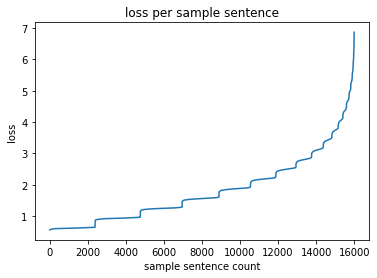

In [25]:
#graph to see distribution of loss over a range
loss1 = loss.copy()
loss.sort()
x = range(16000)
plt.plot(x,loss)
plt.xlabel('sample sentence count')
plt.ylabel('loss')
plt.title('loss per sample sentence')
plt.show()

In [26]:
#getting lengths of inputs for decoder and encoder
train_sample = train_data[:16000].copy()
train_sample["input_len"] = train_sample["input_encoder"].apply(lambda x: (len(x.split())-2))
train_sample["out_len"] = train_sample["output_decoder"].apply(lambda x: (len(x.split())-1))
input_len = train_sample.input_len.values
output_len = train_sample.out_len.values

In [27]:
#correlation coeff between loss and decoder input's length
np.corrcoef(loss1, output_len)

array([[1.        , 0.99957807],
       [0.99957807, 1.        ]])

In [28]:
#correlation coeff between loss and encoder input's length
np.corrcoef(loss1, input_len)

array([[ 1.        , -0.29469745],
       [-0.29469745,  1.        ]])

We confirm our hypothesis, that the length of expected suggestions affects the loss in a positive linear fashion, with almost a correlation coefficient of 1.

This answers our question of what pattern/type of input data affects the error/loss; Longer sentence suggestions are most likely to give us a higher loss.

**Notes:**

looking at some of the sample suggestions provided by the model, we see that it is spitting out meaningful and gramatically correct sentences i.e. meaning that the model has trained on the language perefectly 

then,

why not bleu score?/why bleu score is low?

we are not using BLEU score because it doesen't solve our purpose here, blue score is much better appreciated for machine translation tasks where the expected outputs are fixed i.e can be refferenced from. The task we have here is a general prediction/suggestion english language task which can give stupendous amounts of suggestions thus making it impossible for it to compare suggestions with one particular reference i.e low bleu scores even with just considering uni-grams from references. A much higher bleu score for this task might also indicate very personalized data (poor preprocessing) or overfitting on the training data. 

To get the exactly similar suggestions as we expect, one turn around is since we are using teacher forcing , we can feed in the exact word that we are expecting in the next step , this would give us exactly what we are expecting, thus , making it meaningful to compare with the referenced sentences; evaluating the model performance. This is also exactly the reason, why we are using teacher forcing while getting predictions for post analysis as we are just evaluating the trainned model performance and scope for improvement.